In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from __future__ import division
from __future__ import print_function

import copy
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models, transforms
from datetime import datetime
from pathlib import Path

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101


In [4]:
def train_model(model, dataloaders, criterion, optimizer, save_path, num_epochs=25, is_inception=False):
    Path(save_path).mkdir(parents=True, exist_ok=True)
    since = time.time()

    acc_train_history = []
    loss_train_history = []
    acc_val_history = []
    loss_val_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Cada época tiene una fase de entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Establecer modelo en modo de entrenamiento
            else:
                model.eval()  # Establecer modelo en modo de evaluación

            running_loss = 0.0
            running_corrects = 0

            # Repita los datos.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # cero, los parametros gradientes.
                optimizer.zero_grad()

                # Reenviar la historia de la vía aunque solo esté en el entrenamiento
                with torch.set_grad_enabled(phase == 'train'):
                    # Obtenga salidas del modelo y calcule la pérdida en caso especial para el inicio porque en el 
                    # entrenamiento tiene una salida auxiliar. En el modo de entrenamiento, calculamos la pérdida sumando 
                    #la salida final y la salida auxiliar, pero en las pruebas solo consideramos la salida final.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # retroalimentación + optimizar solo si está en fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # copia profunda del modelo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(), 'loss': loss},
                           f'{save_path}/best.pt')
            if phase == 'val':
                loss_val_history.append(epoch_loss)
                acc_val_history.append(epoch_acc)
                
            if phase == 'train':
                loss_train_history.append(epoch_loss)
                acc_train_history.append(epoch_acc)

            if epoch % 10 == 0:
                torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(), 'loss': loss},
                           f'{save_path}/model_{epoch}.pt')
            torch.save(
                {'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
                 'loss': loss},
                f'{save_path}/last.pt')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # trazando la pérdida y precisión de entrenamiento y validación
    N = num_epochs
    plt.style.use("ggplot")
    fig = plt.figure()
    plt.plot(np.arange(0, N), acc_train_history, label="train_acc")
    plt.plot(np.arange(0, N), acc_val_history, label="val_acc")
    plt.title("Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    fig.savefig(f'Accuracy_{model_name}.png')

    plt.style.use("ggplot")
    fig = plt.figure()
    plt.plot(np.arange(0, N), loss_train_history, label="train_loss")
    plt.plot(np.arange(0, N), loss_val_history, label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    fig.savefig(f'Loss_{model_name}.png')

    # cargar pesos al mejor modelo
    model.load_state_dict(best_model_wts)
    return model, acc_val_history


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Inicialice estas variables que se establecerán en esta declaración if. Cada una de estas variables es específica del modelo.
    model_ft = None
    input_size = 0

    if model_name == "AlexNet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "VGG11-BN":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "SqueezeNet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model_ft.num_classes = num_classes
        input_size = 224
    elif model_name == "DenseNet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "Inceptionv3":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size



Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

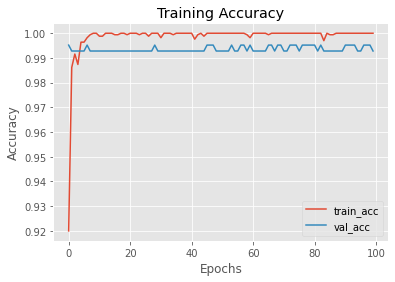

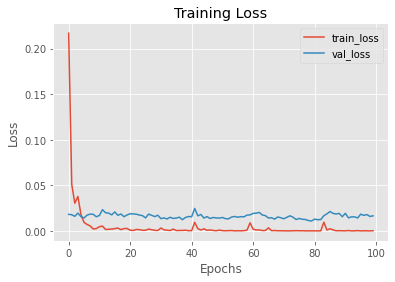

In [6]:
# Directorio de datos de nivel superior. Aquí asumimos que el formato del directorio se ajusta a la estructura ImageFolder
data_dir = "/content/drive/MyDrive/dataset"

# Modelos para elegir [AlexNet, VGG11-BN, SqueezeNet, DenseNet, Inceptionv3]
model_name = "DenseNet"

# Número de clases en el dataset
num_classes = 3

# Tamaño de lote para entrenamiento (cambia según la cantidad de memoria que tengas)
batch_size = 8

# Número de épocas para entrenar
num_epochs = 100

mode = 'test'

# Marcar para extraer características. Cuando es False, ajustamos todo el modelo, cuando es True, solo 
# actualizamos los parámetros de capa remodelados.
feature_extract = False

# Inicializar el modelo para esta ejecución
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Imprime el modelo que acabamos de crear
print(model_ft)

# Aumento y normalización de datos para el entrenamiento, solo normalización para la validación
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# Detectar si tenemos una GPU disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Envía el modelo a la GPU
model_ft = model_ft.to(device)

print("Initializing Datasets and Dataloaders...")

# Creando dataset de entrenamiento y validación
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Creando dataloaders de entrenamiento y validación
dataloaders_dict = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in #num_workers=4
    ['train', 'val']}

# Reúna los parámetros que se optimizarán / actualizarán en esta ejecución. Si estamos afinando, actualizaremos todos 
# los parámetros. Sin embargo, si estamos utilizando el método de extracción de características, solo actualizaremos 
# los parámetros que acabamos de inicializar, es decir, los parámetros con require_grad son True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Configurar la pérdida fxn
criterion = nn.CrossEntropyLoss()

save_path = datetime.now().strftime("%d-%m-%Y_%H%M")

# Entrenar y evaluar
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, save_path=save_path,
                             num_epochs=num_epochs, is_inception=(model_name == "inception"))


